# Regression ABC using MDNs
MDN implementation based on this tutorial: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import torch
from torch.autograd import Variable
import torch.nn as nn

Let's first consider the simple example of an equally weighted mixture of Gaussians with equal mean. One of them with a std of 1, the other 0.1.

In [208]:
def simulator(mu):
    if np.random.rand() < 0.5:
        return np.random.normal(mu,1)
    else:
        return np.random.normal(mu,0.1)

In [209]:
x_obs = 0.0

We use a uniform prior and generate 2500 samples, from which we generate the training set for our MDN.

In [210]:
NSAMPLE = 2500

theta = np.random.uniform(-2, 4, NSAMPLE)
theta.shape

(2500,)

In [212]:
x_data = np.array([simulator(theta_i) for theta_i in theta])
#x_data = summarize(x)
x_data.shape

(2500,)

Here, we adjust the number of hidden units and mixture components in the MDN

In [214]:
NHIDDEN = 50 # hidden units
KMIX = 2 # number of mixtures

In [215]:
class MDN(nn.Module):
    def __init__(self, hidden_size, num_mixtures, input_dim):
        super(MDN, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_size) 
        self.tanh = nn.Tanh()
        self.pi_out = torch.nn.Sequential(
              nn.Linear(hidden_size, num_mixtures),
              nn.Softmax()
            )
        self.sigma_out = nn.Linear(hidden_size, num_mixtures)
        self.mu_out = nn.Linear(hidden_size, num_mixtures)  

    def forward(self, x):
        out = self.fc_in(x)
        out = self.tanh(out)
        out_pi = self.pi_out(out)
        out_sigma = torch.exp(self.sigma_out(out))
        out_mu = self.mu_out(out)
        return (out_pi, out_sigma, out_mu)

Convert the training examples to torch tensors.

In [218]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)).float())
theta_train = Variable(torch.from_numpy(theta.reshape(NSAMPLE, 1)).float(), requires_grad=False)

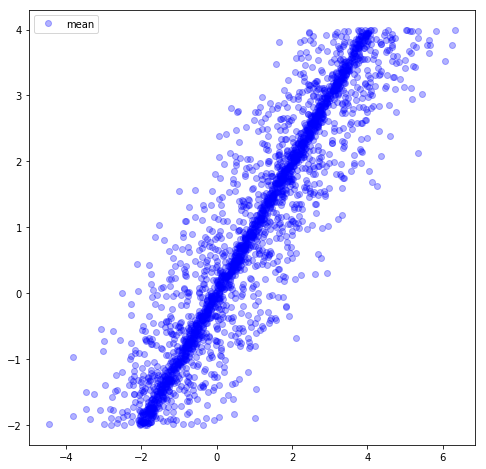

In [220]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy()[:,0],theta_train.data.numpy(),'bo', alpha=0.3, label='mean')
#plt.plot(x_train.data.numpy()[:,1],theta_train.data.numpy(),'ro', alpha=0.3, label='std')
plt.legend()
plt.show()

We now define the loss function, which is simply the negative log likelihood of the training data under our model.

In [221]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalisation factor for gaussian.
def gaussian_distribution(theta, mu, sigma):
    # braodcast subtraction with mean and normalization to sigma
    result = (theta.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = - 0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [222]:
def mdn_loss_function(out_pi, out_sigma, out_mu, theta):
    result = gaussian_distribution(theta, out_mu, out_sigma) * out_pi
    result = torch.sum(result, dim=1)
    result = - torch.log(result)
    return torch.mean(result)

In [223]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=1)

In [224]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/home/dominik/anaconda3/envs/abc/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.394066333770752
500 0.5993705987930298
1000 0.5792468786239624
1500 0.5722172856330872
2000 0.567310094833374
2500 0.5634292960166931
3000 0.5594916939735413
3500 0.5543606877326965
4000 0.5495784282684326
4500 0.5471203923225403
5000 0.544568657875061
5500 0.5419327616691589
6000 0.5405823588371277
6500 0.539637565612793
7000 0.5385182499885559
7500 0.5372543931007385
8000 0.5362792015075684
8500 0.5355212688446045
9000 0.5349587798118591
9500 0.5343684554100037


In [226]:
x_test = Variable(torch.from_numpy(np.array(x_obs).reshape(1, 1)).float())

In [227]:
(out_pi_test, out_sigma_test, out_mu_test) = model(x_test)

out_pi = out_pi_test.data.numpy().T
out_sigma = out_sigma_test.data.numpy().T
out_mu = out_mu_test.data.numpy().T

/home/dominik/anaconda3/envs/abc/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [228]:
xx = np.linspace(-2,2,100)

In [229]:
pdf = np.array([ss.norm.pdf(xx, mu, sigma) * pi for mu, sigma, pi in zip(out_mu, out_sigma, out_pi)])
pdf = pdf.sum(axis=0)

In [230]:
pdf.shape

(100,)

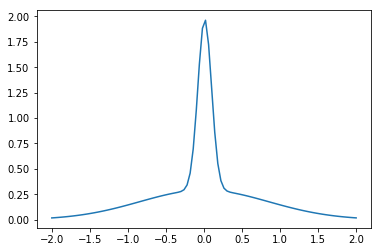

In [231]:
plt.plot(xx, pdf)